In [1]:
import gym
from gym.envs.registration import register

register(
    id='smart_cab-v2',
    entry_point='smart_cab.envs:TaxiEnv')

In [2]:
import gym

# core gym interface is env
env = gym.make('smart_cab:smart_cab-v2')

env.render()

+---------+
|A: | : :B|
| : | : : |
| : : : : |
| | : | : |
|C| : |D: |
+---------+



In [3]:
# env.reset(): Resets the environment and returns a random initial state.
env.reset() 

# env.render(): Renders one frame of the environment (helpful in visualizing the environment)
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

text = """
The filled square represents the taxi, which is yellow without a passenger and green with a passenger.

The pipe ("|") represents a wall which the taxi cannot cross.

A, B, C, D are the possible pickup and destination locations. 

The blue letter represents the current passenger pick-up location.

The pink letter is the current drop-off location.
"""

print(text)


+---------+
|A: | : :B|
| : | : : |
| : : : : |
| | : | : |
|C| : |D: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)

The filled square represents the taxi, which is yellow without a passenger and green with a passenger.

The pipe ("|") represents a wall which the taxi cannot cross.

A, B, C, D are the possible pickup and destination locations. 

The blue letter represents the current passenger pick-up location.

The pink letter is the current drop-off location.



In [4]:
# (taxi row, taxi column, passenger location index, drop-off location index)
# Pick-up/Drop-off --> A - 0, B - 1, C - 2, D - 3, E - 4, F - 5
# Manually set the state and  give it to the environment
state = env.encode(0, 1, 2, 3) 
print("State:", state)

# A number is generated corresponding to a state between 0 and 4200, which turns out to be 57.

env.s = state
env.render()

State: 31
+---------+
|A: | : :B|
| : | : : |
| : : : : |
| | : | : |
|C| : |D: |
+---------+



In [5]:

# Reward Table

text = """
Output is default reward values assigned to each state.

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.

Probability of 1.0 for taking an action to reach a state and 0.0 if the action nvr reach the state

The nextstate is the state we would be in if we take the action at this index of the dict

All the movement actions have a -1 reward, -3 for a wrong pickup and -10 for a wrong dropoff.

If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)

""done"" is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

If the taxi hits the wall, it will accumulate a -1 as well and this will affect a the long-term reward.
"""

print(text)

env.P[57]


Output is default reward values assigned to each state.

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.

Probability of 1.0 for taking an action to reach a state and 0.0 if the action nvr reach the state

The nextstate is the state we would be in if we take the action at this index of the dict

All the movement actions have a -1 reward, -3 for a wrong pickup and -10 for a wrong dropoff.

If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)

""done"" is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

If the taxi hits the wall, it will accumulate a -1 as well and this will affect a the long-term reward.



{0: [(1.0, 157, -1, False)],
 1: [(1.0, 57, -1, False)],
 2: [(1.0, 77, -1, False)],
 3: [(1.0, 57, -1, False)],
 4: [(1.0, 57, -10, False)],
 5: [(1.0, 57, -10, False)]}

# Evaluating Random Policy

In [6]:
import numpy as np

# initialise a random policy where for each action for all states is initialised with a random value
random_policy = np.ones([env.nS, env.nA]) / env.nA

def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    reward_per_episode = 0
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
        reward_per_episode = reward_per_episode + reward
    return reward_per_episode, counter

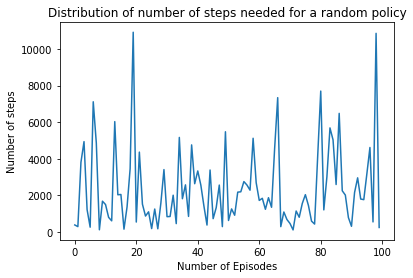

The mean reward for 100 episodes is -9151.56


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
count_list = []
total_reward = 0
for i in range(100):
    reward_per_episode, count = random_policy_steps_count() 
    total_reward = total_reward + reward_per_episode
    count_list.append(count)
plt.plot(count_list)
plt.xlabel('Number of Episodes')
plt.ylabel('Number of steps')
plt.title("Distribution of number of steps needed for a random policy")

plt.show()
print("The mean reward for 100 episodes is {}".format(total_reward/100))

In [8]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        
        env: env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        
        theta: We stop evaluation once our value function change is less than theta for all states.
        
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    
    # Initialise the state-value with 0
    V = np.zeros(env.nS)
    while True:
        
        # delta = change in value of state from one iteration to next
        # there is no change so initialise with 0
        delta = 0  
       
        #for all states
        for state in range(env.nS): 
            
            #initiate value of the state as 0
            val = 0  
            
            #for all actions/action probabilities
            for action,act_prob in enumerate(policy[state]): 
                
                #transition probabilities,state,rewards of each action
                for prob,next_state,reward,done in env.P[state][action]:  
                    
                    # equation to calculate the value of the state
                    # action_probability = probability of taking action a in state s under policy π
                    val = val + act_prob * prob * (reward + discount_factor * V[next_state]) 
            
            # the change would be the max value between the initial change and the current change in value
            delta = max(delta, np.abs(val-V[state]))
            
            # the current state would have that value
            V[state] = val
        
        #break if the change in value is less than the threshold (theta)
        if delta < theta: 
            break
    return np.array(V)



In [9]:
def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    
    def action_value(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        # initialise all action-value to be 0
        A = np.zeros(env.nA)
        
        for a in range(env.nA):
            
            for prob, next_state, reward, done in env.P[state][a]:
                
                # update the value of the current action to that in the next state
                A[a] =  A[a] + prob * (reward + discount_factor * V[next_state])
        
        return A
    
    
    
    
    # Start with a random policy where the action value is the probability of taking an action
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    count = 0
    
    while True:
        
        # Evaluate the current policy
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  
        
        # Condition to check if the policy did improve to the optimal one
        # Set it as True first
        policy_stable = True  
        
        # for each state
        for state in range(env.nS):  
            
            # best action (Highest prob) under current policy
            chosen_act = np.argmax(policy[state]) 
            
            ## find action values in the next state using the current policy
            act_values = action_value(state,curr_pol_val)
            
            # policy improvement
            #find best action
            best_act = np.argmax(act_values)
            
            #Greedily find best action
            if chosen_act != best_act:
                
                # continue to evaluate and improve the current policy
                policy_stable = False
                
            policy[state] = np.eye(env.nA)[best_act]  #update 
        
        count = count + 1
            
        if policy_stable:
            
            print("Steps to converge: ", count)
            
            return policy, curr_pol_val
    
    



In [10]:
# reset the environment
env.reset() 
# evaluate the policy
random_policy = np.ones([env.nS, env.nA]) / env.nA
policy_eval(random_policy,env,discount_factor=0.95)

array([-66.26438752, -71.80792647, -71.42078771, -71.82385699,
       -79.85874125, -79.76644406, -79.85914609, -79.85320521,
       -78.94845049, -78.98965515, -78.18067178, -78.9907127 ,
       -79.89007096, -79.88569714, -79.8903011 , -79.81473063,
       -58.97388718, -71.28332886, -70.42368566, -71.3187026 ,
       -71.76849805, -75.09061994, -74.85861632, -75.10016676,
       -79.84505188, -79.74379722, -79.84549601, -79.83897851,
       -79.0763058 , -79.11250001, -78.40188794, -79.11342896,
       -79.87942213, -79.87462379, -79.87967461, -79.79676993,
       -67.0351757 , -74.29222689, -73.47645597, -74.33919453,
       -79.64432128, -79.7878237 , -79.77780243, -79.78823608,
       -77.71728288, -76.22431024, -77.72383134, -77.6277274 ,
       -79.84088218, -79.84711324, -79.72477359, -79.84727316,
       -79.40240042, -79.37859483, -79.40365295, -78.99236538,
       -76.72709833, -73.48229756, -76.82709925, -76.20673132,
       -79.71298147, -79.82877523, -79.82068901, -79.82

In [11]:
%%time
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy[0]

Steps to converge:  12
CPU times: user 54.1 s, sys: 47.5 ms, total: 54.2 s
Wall time: 54.2 s


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [12]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    reward_per_episode = 0
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state])) 
        curr_state = state
        counter += 1
        env.s = curr_state
        reward_per_episode = reward_per_episode + reward
    
    return reward_per_episode, counter

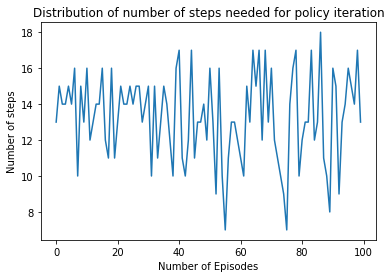

The mean average reward for 100 episodes using the policy iteration optimal policy is 7.72


In [13]:
count_list = []
total_reward = 0
for i in range(100):
    reward_per_episode, count = view_policy(pol_iter_policy) 
    total_reward = total_reward + reward_per_episode
    count_list.append(count)

plt.plot(count_list)
plt.xlabel('Number of Episodes')
plt.ylabel('Number of steps')
plt.title("Distribution of number of steps needed for policy iteration")

plt.show()
print("The mean average reward for 100 episodes using the policy iteration optimal policy is {}".format(total_reward/100))

In [14]:
"""
total_reward = 0
for i in range (100):
    reward_per_episode = view_policy(pol_iter_policy)
    total_reward = total_reward + reward_per_episode

print("The mean average reward for 100 episodes using the policy iteration optimal policy is {}".format(total_reward/100))
"""

'\ntotal_reward = 0\nfor i in range (100):\n    reward_per_episode = view_policy(pol_iter_policy)\n    total_reward = total_reward + reward_per_episode\n\nprint("The mean average reward for 100 episodes using the policy iteration optimal policy is {}".format(total_reward/100))\n'

In [15]:
def value_iteration(theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: env.P represents the transition probabilities of the environment.
             env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
             env.nS is a number of states in the environment. 
             env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def update_action_value(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        
        # initialise all action-value to be 0
        A = np.zeros(env.nA)
        
        for act in range(env.nA):
            
            # get all action value in that given state
            for prob, next_state, reward, done in env.P[state][act]:
                
                # update the value of the current action to that in the next state
                A[act] = A[act] + prob * (reward + discount_factor*V[next_state])
                
        return A
    
    # Value for each state initialise as 0
    V = np.zeros(env.nS)
    
    count = 0
    while True:
        
        #change in value across the state
        delta = 0  
        
        # for all the state
        for state in range(env.nS):
            
            # update the action value based on the given state and the next state
            act_values = update_action_value(state,V)  

            
            #get best action value
            best_act_value = np.max(act_values) 
            
            # the change would be the max value between the initial change and the current change in value
    
            delta = max(delta, np.abs(best_act_value - V[state])) 
            
            # update value to best action value
            V[state] = best_act_value 
            
            count = count + 1
        
        #break if the change in value is less than the threshold (theta)
        #if max improvement less than threshold
        if delta < theta:  
            print("Steps to converge: ", count)
            break
    
    """
    For all states, create new deterministic policy where the policy is a greedy policy based on 
    the value of the states 
    """
    policy = np.zeros([env.nS, env.nA])
    
    for state in range(env.nS):  
        
        act_val = update_action_value(state,V)
        
        best_action = np.argmax(act_val)
        
        policy[state][best_action] = 1
        
    
    
    return policy, V

In [16]:
%%time
env.reset()
val_iter_policy = value_iteration(discount_factor=0.99)
val_iter_policy[0]

Steps to converge:  305000
CPU times: user 4.57 s, sys: 603 ms, total: 5.18 s
Wall time: 4.66 s


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

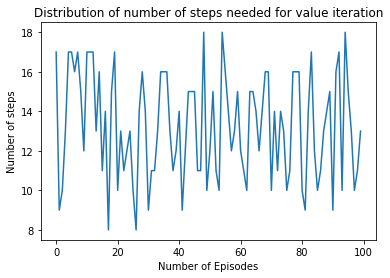

The mean average reward for 100 episodes using the value iteration optimal policy is 7.74


In [20]:
count_list = []
total_reward = 0
for i in range(100):
    reward_per_episode, count = view_policy(pol_iter_policy) 
    total_reward = total_reward + reward_per_episode
    count_list.append(count)
plt.plot(count_list)
plt.xlabel('Number of Episodes')
plt.ylabel('Number of steps')
plt.title("Distribution of number of steps needed for value iteration")

plt.show()
print("The mean average reward for 100 episodes using the value iteration optimal policy is {}".format(total_reward/100))